In [1]:
import json
import string
from collections import defaultdict
from sklearn import linear_model
from sklearn.decomposition import LatentDirichletAllocation 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
with open('winemag-data-130k-v2.json') as f:    
    data = json.load(f)
    
data = [d for d in data if d['price'] is not None and int(d['price']) <= 200]
#data = [d for d in data if d['price'] is not None]

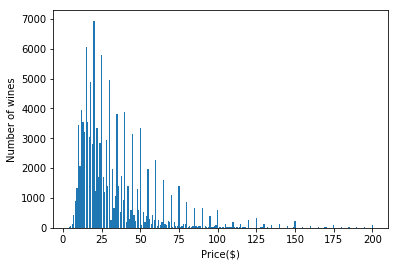

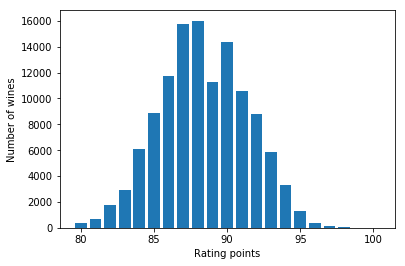

In [3]:
price_counts = defaultdict(int)
points_counts = defaultdict(int)

for d in data:
    price_counts[int(d['price'])] += 1
    points_counts[int(d['points'])] += 1
    
prices = sorted([(p, c) for p,c in price_counts.items()], key=lambda x: x[0])

plt.bar([p[0] for p in prices], [p[1] for p in prices])
plt.xlabel('Price($)')
plt.ylabel('Number of wines')
plt.show()

points = sorted([(p, c) for p,c in points_counts.items()], key=lambda x: x[0])
plt.bar([p[0] for p in points], [p[1] for p in points])
plt.xlabel('Rating points')
plt.ylabel('Number of wines')
plt.show()

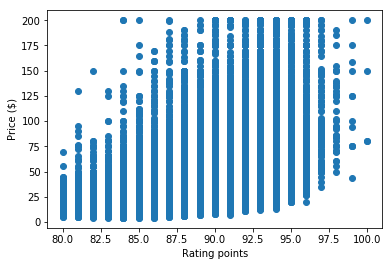

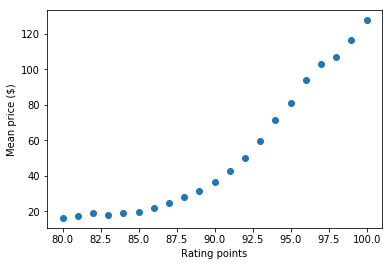

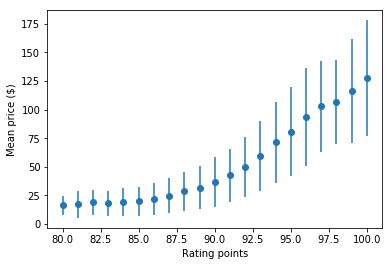

In [4]:
data_by_points = defaultdict(list)
for d in data:
    data_by_points[int(d['points'])].append(d)
    
avg_price_by_points = {k: sum([int(d['price']) for d in v])/len(v) for k,v in data_by_points.items()}
var_price_by_points = {k: math.sqrt(sum([(avg_price_by_points[k] - int(d['price']))**2 for d in v])/len(v)) for k,v in data_by_points.items()}

avg_price_by_points = sorted([(k, v) for k,v in avg_price_by_points.items()])
var_price_by_points = sorted([(k, v) for k,v in var_price_by_points.items()])

plt.scatter([int(d['points']) for d in data], [int(d['price']) for d in data])
plt.xlabel('Rating points')
plt.ylabel('Price ($)')
plt.show()

plt.scatter([p[0] for p in avg_price_by_points], [p[1] for p in avg_price_by_points])
plt.xlabel('Rating points')
plt.ylabel('Mean price ($)')
plt.show()

plt.errorbar([p[0] for p in avg_price_by_points],
             [p[1] for p in avg_price_by_points],
             yerr=[p[1] for p in var_price_by_points],
             fmt='o')
plt.xlabel('Rating points')
plt.ylabel('Mean price ($)')
plt.show()

In [5]:
word_count = defaultdict(int)
punctuation = set(string.punctuation)
digits = set(string.digits)
stop_words = set(stopwords.words('english'))
for d in data:
    r = ''.join([c for c in d['description'].lower() if c not in punctuation and c not in digits])
    for w in r.split():
        if w not in stop_words:
            word_count[w] += 1
            
counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:2500]]
word_Id = dict(zip(words, range(len(words))))
word_set = set(words)

In [6]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['description'].lower() if c not in punctuation and c not in digits])
    for w in r.split():
        if w in words:
            feat[word_Id[w]] += 1
    #feat.append(1)
    return feat

In [7]:
provinces = set()
regions = set()
varieties = set()
wineries = set()

for d in data:
    provinces.add(d['province'])
    regions.add(d['region_1'])
    varieties.add(d['variety'])
    wineries.add(d['winery'])
    
    
province_dict = {p: i for p,i in zip(provinces, range(len(provinces)))}
region_dict = {r: i for r,i in zip(regions, range(len(regions)))}
variety_dict = {v: i for v,i in zip(varieties, range(len(varieties)))}
winery_dict = {w: i for w,i in zip(wineries, range(len(wineries)))}


In [8]:
def feature2(datum):
    feat = [0] * (len(provinces) + len(regions)+ len(varieties) + len(wineries))
    feat[province_dict[datum['province']]] = 1
    feat[region_dict[datum['region_1']]+len(provinces)] = 1
    feat[variety_dict[datum['variety']]+len(provinces)+len(regions)] = 1
    feat[winery_dict[datum['winery']]+len(provinces)+len(regions)+len(varieties)] = 1
    feat.append(1)
    return feat

In [9]:
#predict points
train = data[:len(data)//2]
valid = data[len(data)//2:]

X_train = [feature(d) + feature2(d) for d in train]
y_train = [int(d['points']) for d in train]

X_valid = [feature(d) + feature2(d) for d in valid]
y_valid = [int(d['points']) for d in valid]

In [10]:
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(X_train, y_train)
theta = clf.coef_
predictions = clf.predict(X_valid)


In [11]:
mean = sum([int(d['points']) for d in data])/len(data)
variance = sum([(int(d['points']) - mean)**2 for d in data])/len(data)

print('Mean: ', mean, ' Variance: ', variance)

mse = sum([(x-y)**2 for x,y in zip(predictions, y_valid)])/len(predictions)
print('MSE: ', mse)

Mean:  88.38854297423791  Variance:  9.085357335232706
MSE:  2.52366116844


In [13]:
positive_words = sorted([(words[i], b) for i,b in enumerate(theta[:len(words)])], key=lambda x: x[1], reverse=True)
negative_words = sorted([(words[i], b) for i,b in enumerate(theta[:len(words)])], key=lambda x: x[1])

In [14]:
positive_words[:10]

[('immense', 1.4065095298442096),
 ('memorable', 1.382233216557798),
 ('brilliant', 1.281423206473465),
 ('superb', 1.2367946938255718),
 ('gorgeous', 1.1809992014717221),
 ('smallproduction', 1.1588519947266138),
 ('succulence', 1.1384012169594675),
 ('sumptuous', 1.0983357010964738),
 ('tremendous', 1.0870388213475959),
 ('impressive', 1.070182621665634)]

In [15]:
negative_words[:10]

[('unbalanced', -1.5607739842558941),
 ('strange', -1.5296145868463453),
 ('dull', -1.4308863504007527),
 ('clumsy', -1.3839255901468328),
 ('watery', -1.3560287279737517),
 ('lacks', -1.3413576134232637),
 ('vegetal', -1.2720894900685362),
 ('weedy', -1.1785056969494236),
 ('harsh', -1.1784149651258629),
 ('mealy', -1.124260878789094)]

In [21]:
#predict price
train = data[:len(data)//2]
valid = data[len(data)//2:]

X_train = [feature(d) + feature2(d) for d in train]
y_train = [int(d['price']) for d in train]

X_valid = [feature(d) + feature2(d) for d in valid]
y_valid = [int(d['price']) for d in valid]

In [22]:
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(X_train, y_train)
theta = clf.coef_
predictions = clf.predict(X_valid)


In [23]:
mean = sum([int(d['price']) for d in data])/len(data)
variance = sum([(int(d['price']) - mean)**2 for d in data])/len(data)

print('Mean: ', mean, ' Variance: ', variance)

mse = sum([(x-y)**2 for x,y in zip(predictions, y_valid)])/len(predictions)
print('MSE: ', mse)

Mean:  33.420215640145315  Variance:  613.8946199660832
MSE:  249.005506665


In [24]:
positive_words = sorted([(words[i], b) for i,b in enumerate(theta[:len(words)])], key=lambda x: x[1], reverse=True)
negative_words = sorted([(words[i], b) for i,b in enumerate(theta[:len(words)])], key=lambda x: x[1])

In [25]:
positive_words[:10]

[('saffron', 10.176691597937445),
 ('immense', 10.010894452940764),
 ('smallproduction', 9.9206116884061348),
 ('riserva', 9.705764920147498),
 ('th', 9.522764459124339),
 ('des', 9.2256896900361909),
 ('foresty', 9.1966123169726153),
 ('famous', 8.4730778434133249),
 ('ageability', 8.3274811120779688),
 ('sizable', 8.1481878203767248)]

In [26]:
negative_words[:10]

[('nonvintage', -17.259926534430925),
 ('kabinett', -9.8459173651782557),
 ('entrylevel', -8.8647023495102104),
 ('valuepriced', -7.7885010810747666),
 ('bargain', -7.503931200308287),
 ('wellpriced', -7.2064028234517732),
 ('priced', -6.5221801597787712),
 ('value', -6.4676503756289829),
 ('affordable', -6.3743696407575747),
 ('strange', -6.1716179727771383)]